# IMDB 감성 분류



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AlbertTokenizer, AlbertForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/IMDB Dataset.csv').iloc[:10000, :]
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
9995,"Fun, entertaining movie about WWII German spy ...",positive
9996,Give me a break. How can anyone say that this ...,negative
9997,This movie is a bad movie. But after watching ...,negative
9998,This is a movie that was probably made to ente...,negative


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     10000 non-null  object
 1   sentiment  10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [ ]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
9995,"Fun, entertaining movie about WWII German spy ...",1
9996,Give me a break. How can anyone say that this ...,0
9997,This movie is a bad movie. But after watching ...,0
9998,This is a movie that was probably made to ente...,0


In [ ]:
tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")

tokenized_data = tokenizer(df['review'].tolist(),
    padding=True,
    truncation=True,
    max_length=1024,
    return_tensors='pt')

print("Tokenized data shape:", tokenized_data)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

Tokenized data shape: {'input_ids': tensor([[    2,    53,    16,  ...,     0,     0,     0],
        [    2,    21,  5934,  ...,     0,     0,     0],
        [    2,    31,   289,  ...,     0,     0,     0],
        ...,
        [    2,    48,  1308,  ...,     0,     0,     0],
        [    2,    48,    25,  ...,     0,     0,     0],
        [    2, 23789,   171,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [ ]:
print("Sample tokenized input:", tokenized_data['input_ids'][0])
print("Sample tokenized attention mask:", tokenized_data['attention_mask'][0])
print("Sample tokenized type IDs:", tokenized_data['token_type_ids'][0])

Sample tokenized input: tensor([ 2, 53, 16,  ...,  0,  0,  0])
Sample tokenized attention mask: tensor([1, 1, 1,  ..., 0, 0, 0])
Sample tokenized type IDs: tensor([0, 0, 0,  ..., 0, 0, 0])


In [ ]:
sent_lens = [x.sum() for x in tokenized_data['attention_mask']]
sent_lens[0]

tensor(430)

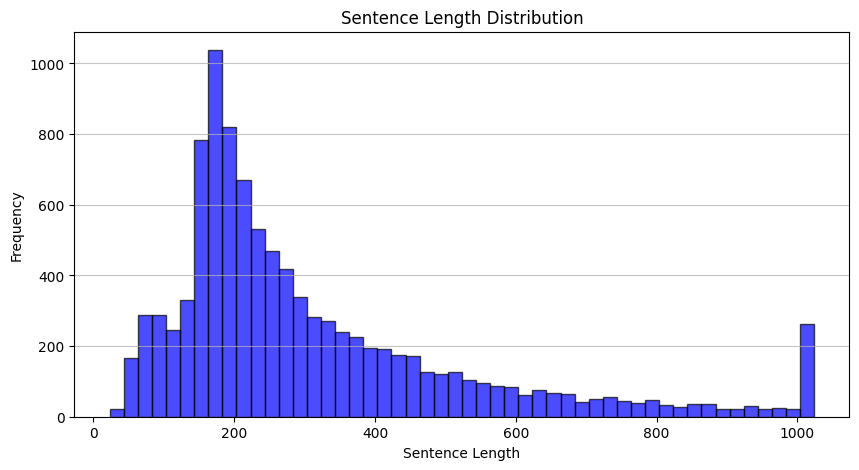

In [ ]:
# 문장 길이 분포 시각화
plt.figure(figsize=(10, 5))
plt.hist(sent_lens, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title('Sentence Length Distribution')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
# plt.xlim(0, 512)
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
class IMDbDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.labels = labels

        self.encoding = tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=max_len,
            return_tensors='pt'
        )

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        return {
            'input_ids': self.encoding['input_ids'][idx],
            'attention_mask': self.encoding['attention_mask'][idx],
            'token_type_ids': self.encoding['token_type_ids'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [ ]:
# split train, validation, test
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42, stratify=df['sentiment'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['sentiment'])

In [ ]:
max_len = 512
train_dataset = IMDbDataset(train_df['review'].tolist(), train_df['sentiment'].tolist(), tokenizer, max_len=256)
val_dataset = IMDbDataset(val_df['review'].tolist(), val_df['sentiment'].tolist(), tokenizer, max_len=256)
test_dataset = IMDbDataset(test_df['review'].tolist(), test_df['sentiment'].tolist(), tokenizer, max_len=256)

batch_len = 128
train_loader = DataLoader(train_dataset, batch_size=batch_len, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_len, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_len, shuffle=False)

In [ ]:
# 1. 랜덤 초기화 모델
model_clear = AlbertForSequenceClassification.from_pretrained("albert-base-v2", ignore_mismatched_sizes=True)
model_clear.init_weights()

# 2. 사전학습 모델 (미세조정 없이)
# model_pre = AlbertForSequenceClassification.from_pretrained("albert-base-v2")

# 3. 사전학습 + fine-tune 모델
# model_fine = copy.deepcopy(model_pretrained)

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_clear

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertSdpaAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=

In [ ]:
# for param in model.albert.parameters():
#     param.requires_grad = False

In [ ]:
# 2. 기존 classifier 구조 확인
print(model_clear.classifier)  # 기본적으로 nn.Linear(768, 2)

# 3. classifier 교체
import torch.nn as nn

# 예: 2-layer MLP classifier로 교체
model_clear.classifier = nn.Sequential(
    nn.Linear(model_clear.config.hidden_size, 256),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

Linear(in_features=768, out_features=2, bias=True)


In [ ]:
model_clear

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertSdpaAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=

## 아무 학습이 되지 않은 모델의 성능

100%|██████████| 8/8 [00:03<00:00,  2.11it/s]

              precision    recall  f1-score   support

           0       0.55      0.06      0.12       497
           1       0.51      0.95      0.66       503

    accuracy                           0.51      1000
   macro avg       0.53      0.51      0.39      1000
weighted avg       0.53      0.51      0.39      1000



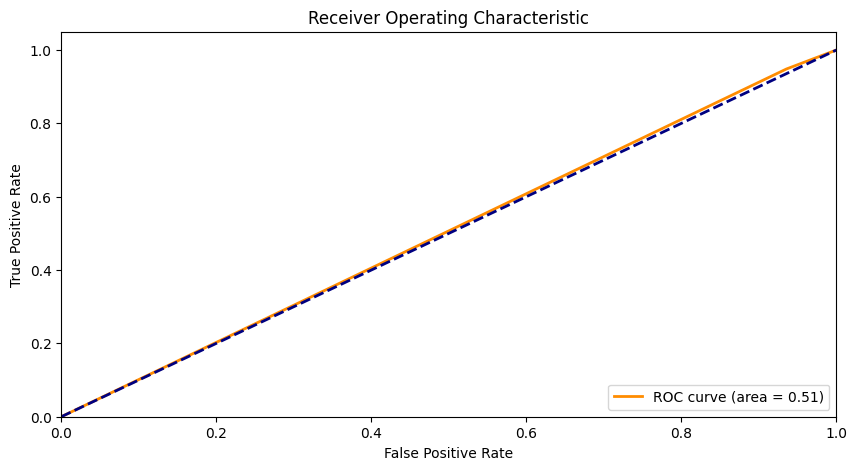

In [ ]:
# test score
model_clear.to(device)
model_clear.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for batch in tqdm(test_loader):

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model_clear(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.round(outputs.logits)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

# plot roc auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



In [ ]:
from torch import optim
from tqdm import tqdm
# train and evaluate function
def train_and_evaluate(model, train_loader, val_loader, epochs=3, lr=5e-5):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)


    train_loss_history = []
    validation_loss_history = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits.squeeze(), labels.float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)
        print(f"Epoch {epoch:2f} :  Train Loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits.squeeze(), labels.float())
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        validation_loss_history.append(avg_val_loss)
        print(f"Epoch {epoch:2f} :  Validation Loss: {avg_val_loss:.4f}")


    return model, train_loss_history, validation_loss_history

In [ ]:
!nvidia-smi

Thu Jul 17 01:32:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P0             78W /  400W |    3035MiB /  40960MiB |     83%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
# train models
model_trained, train_loss_history, validation_loss_history = train_and_evaluate(model_clear, train_loader, val_loader, epochs=10, lr=5e-5)

Epoch 1/10: 100%|██████████| 57/57 [01:07<00:00,  1.18s/it]


Epoch 0.000000 :  Train Loss: 0.6985


Validation: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


Epoch 0.000000 :  Validation Loss: 0.6947


Epoch 2/10: 100%|██████████| 57/57 [01:06<00:00,  1.17s/it]


Epoch 1.000000 :  Train Loss: 0.6947


Validation: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


Epoch 1.000000 :  Validation Loss: 0.6931


Epoch 3/10: 100%|██████████| 57/57 [01:06<00:00,  1.17s/it]


Epoch 2.000000 :  Train Loss: 0.6934


Validation: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


Epoch 2.000000 :  Validation Loss: 0.6932


Epoch 4/10: 100%|██████████| 57/57 [01:06<00:00,  1.17s/it]


Epoch 3.000000 :  Train Loss: 0.6933


Validation: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


Epoch 3.000000 :  Validation Loss: 0.6932


Epoch 5/10: 100%|██████████| 57/57 [01:06<00:00,  1.17s/it]


Epoch 4.000000 :  Train Loss: 0.6932


Validation: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


Epoch 4.000000 :  Validation Loss: 0.6932


Epoch 6/10: 100%|██████████| 57/57 [01:06<00:00,  1.17s/it]


Epoch 5.000000 :  Train Loss: 0.6932


Validation: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


Epoch 5.000000 :  Validation Loss: 0.6932


Epoch 7/10: 100%|██████████| 57/57 [01:06<00:00,  1.17s/it]


Epoch 6.000000 :  Train Loss: 0.6931


Validation: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


Epoch 6.000000 :  Validation Loss: 0.6931


Epoch 8/10: 100%|██████████| 57/57 [01:06<00:00,  1.17s/it]


Epoch 7.000000 :  Train Loss: 0.6932


Validation: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


Epoch 7.000000 :  Validation Loss: 0.6931


Epoch 9/10: 100%|██████████| 57/57 [01:06<00:00,  1.17s/it]


Epoch 8.000000 :  Train Loss: 0.6932


Validation: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


Epoch 8.000000 :  Validation Loss: 0.6931


Epoch 10/10: 100%|██████████| 57/57 [01:06<00:00,  1.17s/it]


Epoch 9.000000 :  Train Loss: 0.6932


Validation: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]

Epoch 9.000000 :  Validation Loss: 0.6931


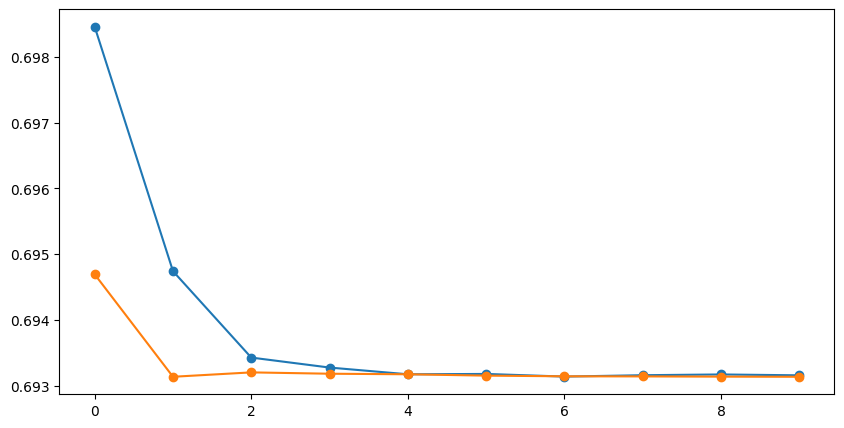

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, 'o-',label='Train Loss')
plt.plot(validation_loss_history, 'o-', label='Validation Loss')
plt.show()

100%|██████████| 8/8 [00:03<00:00,  2.55it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       497
           1       0.50      1.00      0.67       503

    accuracy                           0.50      1000
   macro avg       0.25      0.50      0.33      1000
weighted avg       0.25      0.50      0.34      1000




/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


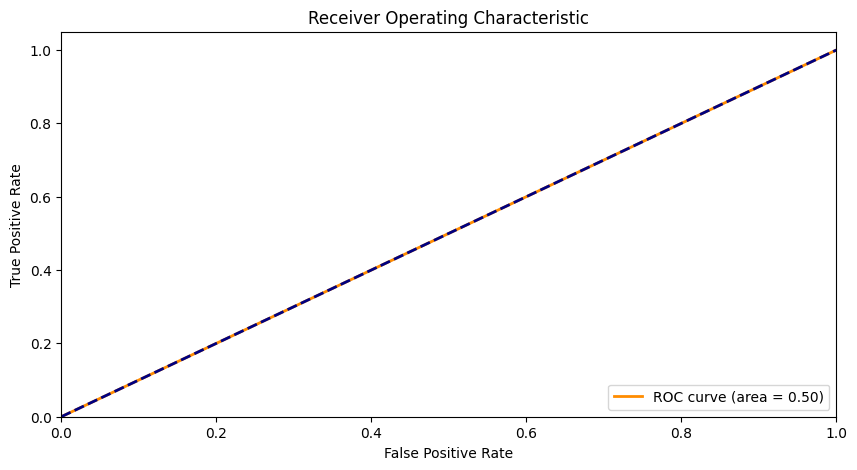

In [ ]:
# test score
model_clear.to(device)
model_clear.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in tqdm(test_loader):

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model_clear(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.round(outputs.logits)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

# plot roc auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



In [ ]:
del model_clear
torch.cuda.empty_cache()

## Pretrain 모델 가져와 튜닝하기

In [ ]:
model_pretrained = AlbertForSequenceClassification.from_pretrained("albert-base-v2")

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for param in model_pretrained.albert.parameters():
    param.requires_grad = False

In [ ]:
# 예: 2-layer MLP classifier로 교체
model_pretrained.classifier = nn.Sequential(
    nn.Linear(model_pretrained.config.hidden_size, 256),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(256, 1),
    nn.Sigmoid()
)
model_pretrained

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertSdpaAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=

In [ ]:
# train models
model_trained, train_loss_history, validation_loss_history = train_and_evaluate(model_pretrained, train_loader, val_loader, epochs=10, lr=5e-5)

Epoch 1/10: 100%|██████████| 57/57 [00:22<00:00,  2.56it/s]


Epoch 0.000000 :  Train Loss: 0.6847


Validation: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


Epoch 0.000000 :  Validation Loss: 0.6677


Epoch 2/10: 100%|██████████| 57/57 [00:22<00:00,  2.56it/s]


Epoch 1.000000 :  Train Loss: 0.6317


Validation: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


Epoch 1.000000 :  Validation Loss: 0.5972


Epoch 3/10: 100%|██████████| 57/57 [00:22<00:00,  2.56it/s]


Epoch 2.000000 :  Train Loss: 0.5942


Validation: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


Epoch 2.000000 :  Validation Loss: 0.6103


Epoch 4/10: 100%|██████████| 57/57 [00:22<00:00,  2.56it/s]


Epoch 3.000000 :  Train Loss: 0.5895


Validation: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


Epoch 3.000000 :  Validation Loss: 0.5428


Epoch 5/10: 100%|██████████| 57/57 [00:22<00:00,  2.56it/s]


Epoch 4.000000 :  Train Loss: 0.5597


Validation: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


Epoch 4.000000 :  Validation Loss: 0.5259


Epoch 6/10: 100%|██████████| 57/57 [00:22<00:00,  2.56it/s]


Epoch 5.000000 :  Train Loss: 0.5459


Validation: 100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


Epoch 5.000000 :  Validation Loss: 0.5174


Epoch 7/10: 100%|██████████| 57/57 [00:22<00:00,  2.56it/s]


Epoch 6.000000 :  Train Loss: 0.5478


Validation: 100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


Epoch 6.000000 :  Validation Loss: 0.5203


Epoch 8/10: 100%|██████████| 57/57 [00:22<00:00,  2.55it/s]


Epoch 7.000000 :  Train Loss: 0.5421


Validation: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


Epoch 7.000000 :  Validation Loss: 0.4888


Epoch 9/10: 100%|██████████| 57/57 [00:22<00:00,  2.55it/s]


Epoch 8.000000 :  Train Loss: 0.5704


Validation: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


Epoch 8.000000 :  Validation Loss: 0.5332


Epoch 10/10: 100%|██████████| 57/57 [00:22<00:00,  2.55it/s]


Epoch 9.000000 :  Train Loss: 0.5353


Validation: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]

Epoch 9.000000 :  Validation Loss: 0.4880


In [ ]:
# train models
model_trained, train_loss_history, validation_loss_history = train_and_evaluate(model_pretrained, train_loader, val_loader, epochs=5, lr=5e-5)

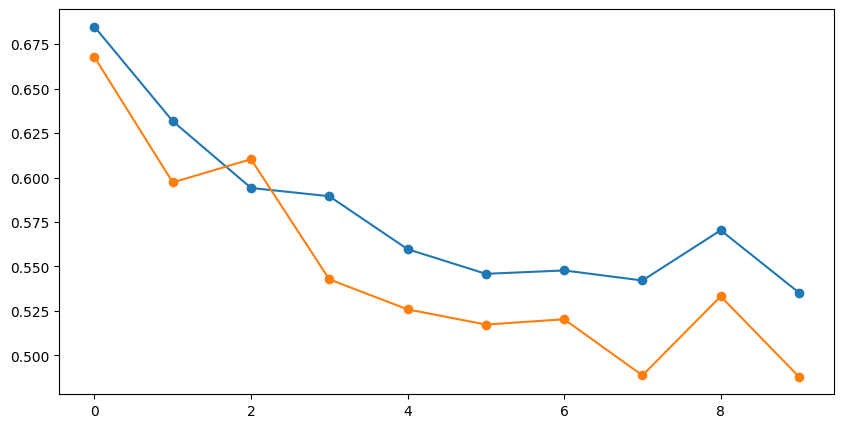

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, 'o-',label='Train Loss')
plt.plot(validation_loss_history, 'o-', label='Validation Loss')
plt.show()

In [ ]:
# train models
model_trained, train_loss_history, validation_loss_history = train_and_evaluate(model_pretrained, train_loader, val_loader, epochs=5, lr=5e-5)

Epoch 1/5: 100%|██████████| 57/57 [00:22<00:00,  2.56it/s]


Epoch 0.000000 :  Train Loss: 0.5405


Validation: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


Epoch 0.000000 :  Validation Loss: 0.4842


Epoch 2/5: 100%|██████████| 57/57 [00:22<00:00,  2.56it/s]


Epoch 1.000000 :  Train Loss: 0.5284


Validation: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


Epoch 1.000000 :  Validation Loss: 0.5137


Epoch 3/5: 100%|██████████| 57/57 [00:22<00:00,  2.56it/s]


Epoch 2.000000 :  Train Loss: 0.5233


Validation: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


Epoch 2.000000 :  Validation Loss: 0.5285


Epoch 4/5: 100%|██████████| 57/57 [00:22<00:00,  2.56it/s]


Epoch 3.000000 :  Train Loss: 0.5310


Validation: 100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


Epoch 3.000000 :  Validation Loss: 0.4812


Epoch 5/5: 100%|██████████| 57/57 [00:22<00:00,  2.56it/s]


Epoch 4.000000 :  Train Loss: 0.5231


Validation: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]

Epoch 4.000000 :  Validation Loss: 0.5444


In [ ]:
outputs.logits.cpu().numpy().ravel()

array([0.20956796, 0.3601224 , 0.215411  , 0.6942235 , 0.800765  ,
       0.6531217 , 0.60367686, 0.7440408 , 0.24280174, 0.70337254,
       0.4932914 , 0.59777004, 0.4143927 , 0.367951  , 0.7804861 ,
       0.6074858 , 0.65275073, 0.30061632, 0.6715474 , 0.5017116 ,
       0.15360679, 0.76728296, 0.52750593, 0.8340413 , 0.3235427 ,
       0.46486738, 0.78180146, 0.70691943, 0.59173465, 0.45726687,
       0.30574128, 0.17651382, 0.8537273 , 0.13159107, 0.7842359 ,
       0.537692  , 0.55521417, 0.2656043 , 0.9069    , 0.40663806,
       0.69397706, 0.21128833, 0.1183776 , 0.92981535, 0.67916405,
       0.5681629 , 0.37809515, 0.14706914, 0.8380531 , 0.566284  ,
       0.90424055, 0.4874285 , 0.7308512 , 0.51066613, 0.5747443 ,
       0.3234878 , 0.51310915, 0.5285416 , 0.6797468 , 0.60083705,
       0.2750844 , 0.6104678 , 0.59581256, 0.52674073, 0.48764512,
       0.79540575, 0.12035278, 0.7136952 , 0.1644979 , 0.49566907,
       0.7115976 , 0.33013028, 0.46227118, 0.42309543, 0.30902

100%|██████████| 8/8 [00:03<00:00,  2.55it/s]


              precision    recall  f1-score   support

           0       0.62      0.95      0.75       497
           1       0.90      0.43      0.58       503

    accuracy                           0.69      1000
   macro avg       0.76      0.69      0.67      1000
weighted avg       0.76      0.69      0.67      1000



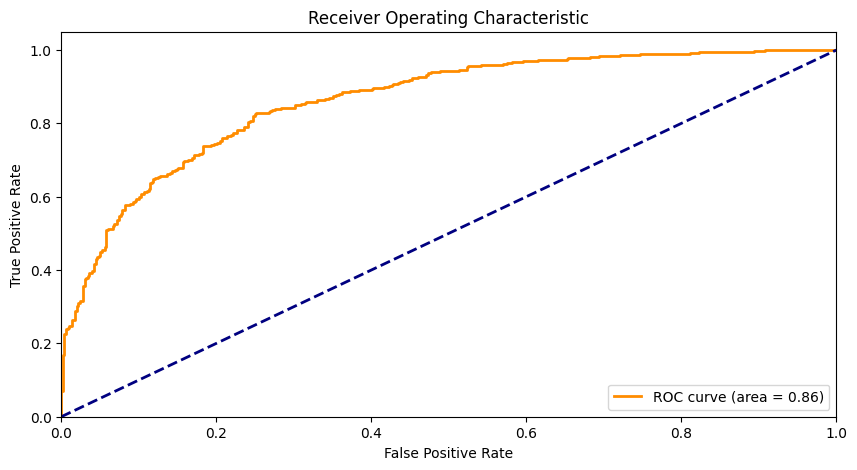

In [ ]:
# test score
model_trained.to(device)
model_trained.eval()
y_true = []
y_pred = []
logits_all = []

with torch.no_grad():
    for batch in tqdm(test_loader):

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model_trained(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.round(outputs.logits)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        logits_all.extend(outputs.logits.cpu().numpy())

from sklearn.metrics import classification_report
print()
print(classification_report(y_true, y_pred))

# plot roc auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
fpr, tpr, thresholds = roc_curve(y_true, logits_all)
roc_auc = roc_auc_score(y_true, logits_all)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



In [ ]:
# true인 데이터만 filtering
true_df = df[df['sentiment'] == 1]
true_df

False

In [ ]:
true_pos = [p[0] for p, l in zip(logits_all, y_true) if l == 1]
true_neg = [p[0] for p, l in zip(logits_all, y_true) if l == 0]

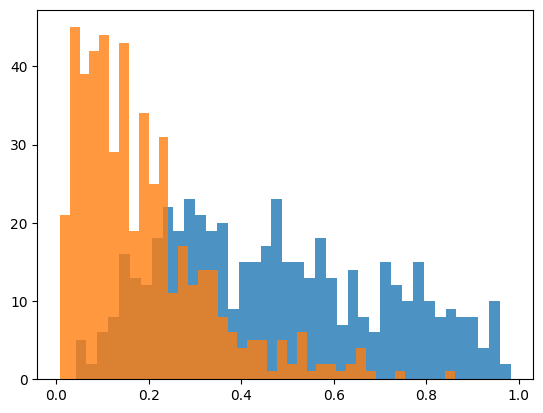

In [ ]:
plt.hist(true_pos, bins = 40, alpha = 0.8)
plt.hist(true_neg, bins = 40, alpha = 0.8)
plt.show()

In [ ]:
y_true = []
y_pred = []
logits_all = []


with torch.no_grad():
    for batch in tqdm(test_loader):

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model_trained(input_ids=input_ids, attention_mask=attention_mask)
        preds = outputs.logits > 0.4
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        logits_all.extend(outputs.logits.cpu().numpy())

from sklearn.metrics import classification_report
print()
print(classification_report(y_true, y_pred))

100%|██████████| 8/8 [00:03<00:00,  2.56it/s]


              precision    recall  f1-score   support

           0       0.68      0.92      0.78       497
           1       0.87      0.57      0.69       503

    accuracy                           0.74      1000
   macro avg       0.78      0.74      0.73      1000
weighted avg       0.78      0.74      0.73      1000

